In [10]:
import aug_util as aug
import wv_util as wv
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline
#import matplotlib, copy, skimage, os, tifffile
from skimage import io, morphology, draw
import gdal
from PIL import Image
import random
import json
from tqdm import tqdm
import io
import glob
import shutil
import os
import geopandas as gpd

In [5]:
# modified to buffer the bounding boxes by 15 pixels
# return uids of bboxes as well 
# this is for geojson with 2 classes: damaged and non-damaged
def get_labels_w_uid_nondamaged(fname):
    """
    Gets label data from a geojson label file
    Args:
        fname: file path to an xView geojson label file
    Output:
        Returns three arrays: coords, chips, and classes corresponding to the
            coordinates, file-names, and classes for each ground truth.
    """
      # debug
    x_off = 15
    y_off = 15
    right_shift = 5  # how much shift to the right 
    add_np = np.array([-x_off + right_shift, -y_off, x_off + right_shift, y_off])  # shift to the rihgt
    with open(fname) as f:
        data = json.load(f)

    coords = np.zeros((len(data['features']),4))
    chips = np.zeros((len(data['features'])),dtype="object")
    classes = np.zeros((len(data['features'])))
    # debug
    uids = np.zeros((len(data['features'])))

    for i in tqdm(range(len(data['features']))):
        if data['features'][i]['properties']['bb'] != []:
            try: 
                b_id = data['features'][i]['properties']['id']
#                 if b_id == '20170831_105001000B95E100_3020021_jpeg_compressed_06_01.tif':
#                     print('found chip!')
                bbox = data['features'][i]['properties']['bb'][1:-1].split(",")
                val = np.array([int(num) for num in data['features'][i]['properties']['bb'][1:-1].split(",")])
                
                ymin = val[3]
                ymax = val[1]
                val[1] =  ymin
                val[3] = ymax
                chips[i] = b_id
                classes[i] = data['features'][i]['properties']['TYPE_ID']
                # debug
                uids[i] = int(data['features'][i]['properties']['bb_uid'])
            except:
#                 print('i:', i)
#                 print(data['features'][i]['properties']['bb'])
                  pass
            if val.shape[0] != 4:
                print("Issues at %d!" % i)
            else:
                coords[i] = val
        else:
            chips[i] = 'None'
    # debug
    # added offsets to each coordinates
    # need to check the validity of bbox maybe
    coords = np.add(coords, add_np)
    
    return coords, chips, classes, uids

In [6]:
# modified to buffer the bounding boxes by 15 pixels
# return uids of bboxes as well 
def get_labels_w_uid(fname):
    """
    Gets label data from a geojson label file
    Args:
        fname: file path to an xView geojson label file
    Output:
        Returns three arrays: coords, chips, and classes corresponding to the
            coordinates, file-names, and classes for each ground truth.
    """
      # debug
    x_off = 15
    y_off = 15
    right_shift = 5  # how much shift to the right 
    add_np = np.array([-x_off + right_shift, -y_off, x_off + right_shift, y_off])  # shift to the rihgt
    with open(fname) as f:
        data = json.load(f)

    coords = np.zeros((len(data['features']),4))
    chips = np.zeros((len(data['features'])),dtype="object")
    classes = np.zeros((len(data['features'])))
    # debug
    uids = np.zeros((len(data['features'])))

    for i in tqdm(range(len(data['features']))):
        if data['features'][i]['properties']['bb'] != []:
            try: 
                b_id = data['features'][i]['properties']['IMAGE_ID']
#                 if b_id == '20170831_105001000B95E100_3020021_jpeg_compressed_06_01.tif':
#                     print('found chip!')
                bbox = data['features'][i]['properties']['bb'][1:-1].split(",")
                val = np.array([int(num) for num in data['features'][i]['properties']['bb'][1:-1].split(",")])
                
                ymin = val[3]
                ymax = val[1]
                val[1] =  ymin
                val[3] = ymax
                chips[i] = b_id
                classes[i] = data['features'][i]['properties']['TYPE_ID']
                # debug
                uids[i] = int(data['features'][i]['properties']['bb_uid'])
            except:
#                 print('i:', i)
#                 print(data['features'][i]['properties']['bb'])
                  pass
            if val.shape[0] != 4:
                print("Issues at %d!" % i)
            else:
                coords[i] = val
        else:
            chips[i] = 'None'
    # debug
    # added offsets to each coordinates
    # need to check the validity of bbox maybe
    coords = np.add(coords, add_np)
    
    return coords, chips, classes, uids

In [7]:
#fname = '../just_buildings_w_uid.geojson'
fname = '../added_non_damaged_cleaned.geojson'
coords, chips, classes, uids = get_labels_w_uid_nondamaged(fname)

100%|██████████| 124480/124480 [00:00<00:00, 144612.62it/s]


In [8]:
# draw boxs that specify index number on each bboxes

import numpy as np
from PIL import Image
import tensorflow as tf
from PIL import Image, ImageDraw
import skimage.filters as filters
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

# draw bboxes with bbox uid

def draw_bboxes_withindex(img,boxes, uids):
    """
    A helper function to draw bounding box rectangles on images
    Args:
        img: image to be drawn on in array format
        boxes: An (N,4) array of bounding boxes
    Output:
        Image with drawn bounding boxes
    """
    source = Image.fromarray(img)
    draw = ImageDraw.Draw(source)
    w2,h2 = (img.shape[0],img.shape[1])
    
    font = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerif.ttf', 40)
    #font = ImageFont.truetype('arial.ttf', 24)


    idx = 0

    for b in boxes:
        xmin,ymin,xmax,ymax = b
        
        for j in range(3):
            draw.rectangle(((xmin+j, ymin+j), (xmax+j, ymax+j)), outline="red")
        draw.text((xmin-70, ymin-20), str(uids[idx]), font = font, fill = "orange")
        idx +=1
    return source



/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
# draw boxs that specify index number on each bboxes

import numpy as np
from PIL import Image
import tensorflow as tf
from PIL import Image, ImageDraw
import skimage.filters as filters
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

# draw bboxes with bbox uid

def draw_bboxes_withindex_multiclass(img,boxes,classes, uids):
    """
    A helper function to draw bounding box rectangles on images
    Args:
        img: image to be drawn on in array format
        boxes: An (N,4) array of bounding boxes
    Output:
        Image with drawn bounding boxes
    """
    source = Image.fromarray(img)
    draw = ImageDraw.Draw(source)
    w2,h2 = (img.shape[0],img.shape[1])
    
    font = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerif.ttf', 40)
    #font = ImageFont.truetype('arial.ttf', 24)


    idx = 0

    for b in boxes:
        xmin,ymin,xmax,ymax = b
        if classes[idx] == 1: 
        
            for j in range(3):
                draw.rectangle(((xmin+j, ymin+j), (xmax+j, ymax+j)), outline="red")
        else:
            for j in range(3):
                draw.rectangle(((xmin+j, ymin+j), (xmax+j, ymax+j)), outline="green")
        draw.text((xmin+70, ymin+20), str(uids[idx]), font = font, fill = "orange")
        idx +=1
    return source



/home/ubuntu/anyan/harvey_data/filtered_converted_image/20170831_105001000B95E100_3020021_jpeg_compressed_05_02.tif


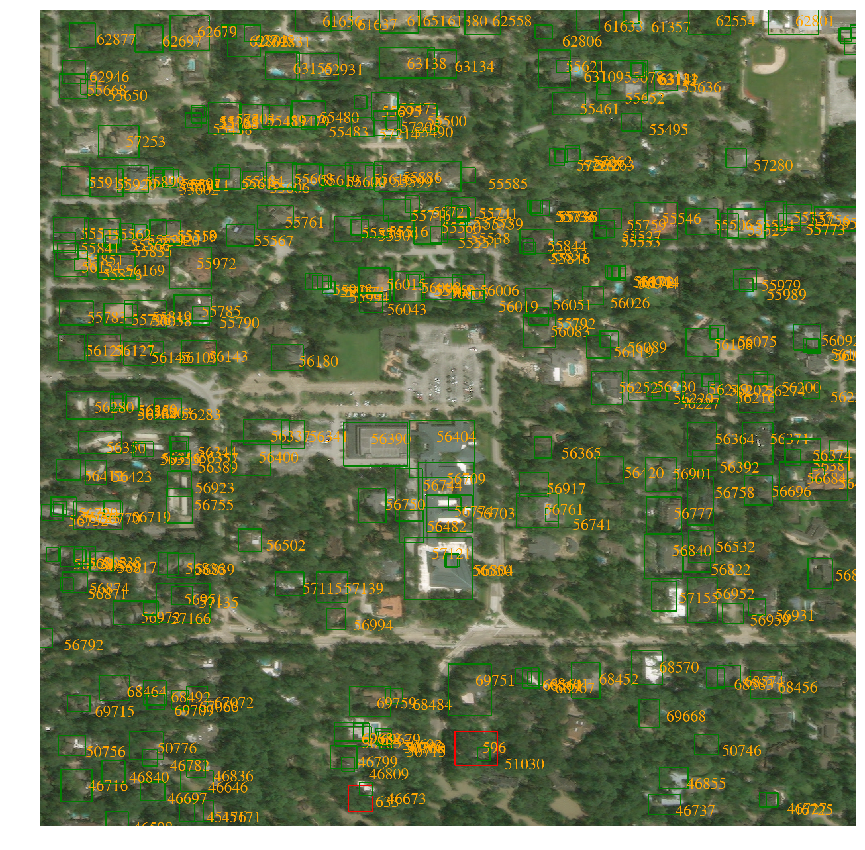

In [17]:
#Load an image
path = '/home/ubuntu/anyan/harvey_data/filtered_converted_image/'
#chip_name = '20170829_1040010032211E00_2112023_jpeg_compressed_10_10.tif' # with blackout
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_01.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_04_04.tif'
chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_05_02.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_05_04.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_02.tif'

#chip_name = '20170902_105001000B9D7F00_3030321_jpeg_compressed_07_03.tif'
#chip_name = '20170902_105001000B9D7E00_3030211_jpeg_compressed_07_09.tif'

chip_fullname = path + chip_name
print(chip_fullname)
arr = wv.get_image(chip_fullname)
coords_chip = coords[chips==chip_name]
# print(coords_chip)

# add offsets
# x_off = 15
# y_off = 15
# add_np = np.array([-x_off, -y_off, x_off, y_off])
# coords_chip = np.add(coords_chip, add_np)

# CAUTION: should check the wether the shifted bboxes are within big image boundary

classes_chip = classes[chips==chip_name].astype(np.int64)
uids_chip = uids[chips == chip_name].astype(np.int64)
#labelled = aug.draw_bboxes(arr,coords_chip[classes_chip ==1])
labelled = draw_bboxes_withindex_multiclass(arr,coords_chip,classes_chip, uids_chip)

#labelled = aug.draw_bboxes(arr,coords[classes ==1])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(labelled)

# print(arr.shape)
# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(arr)

In [14]:
# delete bboxes based on bbox uid
# return new geojson
# fname = '../just_buildings_w_uid.geojson'
def delete_bbox_from_geojson(old_geojson, rows_to_delete):
    gfN = gpd.read_file(old_geojson)
    index_list = []
    df_len = len(gfN)
    

    for i in range(0, df_len):
        print('idx', i)
        series_tmp = gfN.loc[i]
        if series_tmp['bb_uid'] in set(rows_to_delete):
            continue
        index_list.append(i)
    geometries = [xy for xy in list(gfN.iloc[index_list]['geometry'])]
    crs = {'init': 'epsg:4326'}
    gf = gpd.GeoDataFrame(gfN.iloc[index_list], crs=crs, geometry=geometries)

# geometries = [shapely.geometry.Point(xy) for xy in zip(df.lng, df.lat)]
# gf = gpd.GeoDataFrame(gfN.iloc[0],)
    parent_folder = os.path.abspath(old_geojson + "/../")

    # get training or test dir name
    f_base = os.path.basename(old_geojson)
    
    save_name = ''.join(f_base.split('.')[0:-1]) +'_cleaned.geojson'
    print(save_name)
    gf.to_file(parent_folder+'/'+ save_name, driver='GeoJSON')
     
 

In [124]:
# rows_to_delete = [8591, 978]
# delete_bbox_from_geojson(fname, rows_to_delete)

idx 0
idx 1
idx 2
idx 3
idx 4
idx 5
idx 6
idx 7
idx 8
idx 9
idx 10
idx 11
idx 12
idx 13
idx 14
idx 15
idx 16
idx 17
idx 18
idx 19
idx 20
idx 21
idx 22
idx 23
idx 24
idx 25
idx 26
idx 27
idx 28
idx 29
idx 30
idx 31
idx 32
idx 33
idx 34
idx 35
idx 36
idx 37
idx 38
idx 39
idx 40
idx 41
idx 42
idx 43
idx 44
idx 45
idx 46
idx 47
idx 48
idx 49
idx 50
idx 51
idx 52
idx 53
idx 54
idx 55
idx 56
idx 57
idx 58
idx 59
idx 60
idx 61
idx 62
idx 63
idx 64
idx 65
idx 66
idx 67
idx 68
idx 69
idx 70
idx 71
idx 72
idx 73
idx 74
idx 75
idx 76
idx 77
idx 78
idx 79
idx 80
idx 81
idx 82
idx 83
idx 84
idx 85
idx 86
idx 87
idx 88
idx 89
idx 90
idx 91
idx 92
idx 93
idx 94
idx 95
idx 96
idx 97
idx 98
idx 99
idx 100
idx 101
idx 102
idx 103
idx 104
idx 105
idx 106
idx 107
idx 108
idx 109
idx 110
idx 111
idx 112
idx 113
idx 114
idx 115
idx 116
idx 117
idx 118
idx 119
idx 120
idx 121
idx 122
idx 123
idx 124
idx 125
idx 126
idx 127
idx 128
idx 129
idx 130
idx 131
idx 132
idx 133
idx 134
idx 135
idx 136
idx 137
idx 13

idx 1107
idx 1108
idx 1109
idx 1110
idx 1111
idx 1112
idx 1113
idx 1114
idx 1115
idx 1116
idx 1117
idx 1118
idx 1119
idx 1120
idx 1121
idx 1122
idx 1123
idx 1124
idx 1125
idx 1126
idx 1127
idx 1128
idx 1129
idx 1130
idx 1131
idx 1132
idx 1133
idx 1134
idx 1135
idx 1136
idx 1137
idx 1138
idx 1139
idx 1140
idx 1141
idx 1142
idx 1143
idx 1144
idx 1145
idx 1146
idx 1147
idx 1148
idx 1149
idx 1150
idx 1151
idx 1152
idx 1153
idx 1154
idx 1155
idx 1156
idx 1157
idx 1158
idx 1159
idx 1160
idx 1161
idx 1162
idx 1163
idx 1164
idx 1165
idx 1166
idx 1167
idx 1168
idx 1169
idx 1170
idx 1171
idx 1172
idx 1173
idx 1174
idx 1175
idx 1176
idx 1177
idx 1178
idx 1179
idx 1180
idx 1181
idx 1182
idx 1183
idx 1184
idx 1185
idx 1186
idx 1187
idx 1188
idx 1189
idx 1190
idx 1191
idx 1192
idx 1193
idx 1194
idx 1195
idx 1196
idx 1197
idx 1198
idx 1199
idx 1200
idx 1201
idx 1202
idx 1203
idx 1204
idx 1205
idx 1206
idx 1207
idx 1208
idx 1209
idx 1210
idx 1211
idx 1212
idx 1213
idx 1214
idx 1215
idx 1216
idx 1217
i

idx 2156
idx 2157
idx 2158
idx 2159
idx 2160
idx 2161
idx 2162
idx 2163
idx 2164
idx 2165
idx 2166
idx 2167
idx 2168
idx 2169
idx 2170
idx 2171
idx 2172
idx 2173
idx 2174
idx 2175
idx 2176
idx 2177
idx 2178
idx 2179
idx 2180
idx 2181
idx 2182
idx 2183
idx 2184
idx 2185
idx 2186
idx 2187
idx 2188
idx 2189
idx 2190
idx 2191
idx 2192
idx 2193
idx 2194
idx 2195
idx 2196
idx 2197
idx 2198
idx 2199
idx 2200
idx 2201
idx 2202
idx 2203
idx 2204
idx 2205
idx 2206
idx 2207
idx 2208
idx 2209
idx 2210
idx 2211
idx 2212
idx 2213
idx 2214
idx 2215
idx 2216
idx 2217
idx 2218
idx 2219
idx 2220
idx 2221
idx 2222
idx 2223
idx 2224
idx 2225
idx 2226
idx 2227
idx 2228
idx 2229
idx 2230
idx 2231
idx 2232
idx 2233
idx 2234
idx 2235
idx 2236
idx 2237
idx 2238
idx 2239
idx 2240
idx 2241
idx 2242
idx 2243
idx 2244
idx 2245
idx 2246
idx 2247
idx 2248
idx 2249
idx 2250
idx 2251
idx 2252
idx 2253
idx 2254
idx 2255
idx 2256
idx 2257
idx 2258
idx 2259
idx 2260
idx 2261
idx 2262
idx 2263
idx 2264
idx 2265
idx 2266
i

idx 3171
idx 3172
idx 3173
idx 3174
idx 3175
idx 3176
idx 3177
idx 3178
idx 3179
idx 3180
idx 3181
idx 3182
idx 3183
idx 3184
idx 3185
idx 3186
idx 3187
idx 3188
idx 3189
idx 3190
idx 3191
idx 3192
idx 3193
idx 3194
idx 3195
idx 3196
idx 3197
idx 3198
idx 3199
idx 3200
idx 3201
idx 3202
idx 3203
idx 3204
idx 3205
idx 3206
idx 3207
idx 3208
idx 3209
idx 3210
idx 3211
idx 3212
idx 3213
idx 3214
idx 3215
idx 3216
idx 3217
idx 3218
idx 3219
idx 3220
idx 3221
idx 3222
idx 3223
idx 3224
idx 3225
idx 3226
idx 3227
idx 3228
idx 3229
idx 3230
idx 3231
idx 3232
idx 3233
idx 3234
idx 3235
idx 3236
idx 3237
idx 3238
idx 3239
idx 3240
idx 3241
idx 3242
idx 3243
idx 3244
idx 3245
idx 3246
idx 3247
idx 3248
idx 3249
idx 3250
idx 3251
idx 3252
idx 3253
idx 3254
idx 3255
idx 3256
idx 3257
idx 3258
idx 3259
idx 3260
idx 3261
idx 3262
idx 3263
idx 3264
idx 3265
idx 3266
idx 3267
idx 3268
idx 3269
idx 3270
idx 3271
idx 3272
idx 3273
idx 3274
idx 3275
idx 3276
idx 3277
idx 3278
idx 3279
idx 3280
idx 3281
i

idx 4200
idx 4201
idx 4202
idx 4203
idx 4204
idx 4205
idx 4206
idx 4207
idx 4208
idx 4209
idx 4210
idx 4211
idx 4212
idx 4213
idx 4214
idx 4215
idx 4216
idx 4217
idx 4218
idx 4219
idx 4220
idx 4221
idx 4222
idx 4223
idx 4224
idx 4225
idx 4226
idx 4227
idx 4228
idx 4229
idx 4230
idx 4231
idx 4232
idx 4233
idx 4234
idx 4235
idx 4236
idx 4237
idx 4238
idx 4239
idx 4240
idx 4241
idx 4242
idx 4243
idx 4244
idx 4245
idx 4246
idx 4247
idx 4248
idx 4249
idx 4250
idx 4251
idx 4252
idx 4253
idx 4254
idx 4255
idx 4256
idx 4257
idx 4258
idx 4259
idx 4260
idx 4261
idx 4262
idx 4263
idx 4264
idx 4265
idx 4266
idx 4267
idx 4268
idx 4269
idx 4270
idx 4271
idx 4272
idx 4273
idx 4274
idx 4275
idx 4276
idx 4277
idx 4278
idx 4279
idx 4280
idx 4281
idx 4282
idx 4283
idx 4284
idx 4285
idx 4286
idx 4287
idx 4288
idx 4289
idx 4290
idx 4291
idx 4292
idx 4293
idx 4294
idx 4295
idx 4296
idx 4297
idx 4298
idx 4299
idx 4300
idx 4301
idx 4302
idx 4303
idx 4304
idx 4305
idx 4306
idx 4307
idx 4308
idx 4309
idx 4310
i

idx 5229
idx 5230
idx 5231
idx 5232
idx 5233
idx 5234
idx 5235
idx 5236
idx 5237
idx 5238
idx 5239
idx 5240
idx 5241
idx 5242
idx 5243
idx 5244
idx 5245
idx 5246
idx 5247
idx 5248
idx 5249
idx 5250
idx 5251
idx 5252
idx 5253
idx 5254
idx 5255
idx 5256
idx 5257
idx 5258
idx 5259
idx 5260
idx 5261
idx 5262
idx 5263
idx 5264
idx 5265
idx 5266
idx 5267
idx 5268
idx 5269
idx 5270
idx 5271
idx 5272
idx 5273
idx 5274
idx 5275
idx 5276
idx 5277
idx 5278
idx 5279
idx 5280
idx 5281
idx 5282
idx 5283
idx 5284
idx 5285
idx 5286
idx 5287
idx 5288
idx 5289
idx 5290
idx 5291
idx 5292
idx 5293
idx 5294
idx 5295
idx 5296
idx 5297
idx 5298
idx 5299
idx 5300
idx 5301
idx 5302
idx 5303
idx 5304
idx 5305
idx 5306
idx 5307
idx 5308
idx 5309
idx 5310
idx 5311
idx 5312
idx 5313
idx 5314
idx 5315
idx 5316
idx 5317
idx 5318
idx 5319
idx 5320
idx 5321
idx 5322
idx 5323
idx 5324
idx 5325
idx 5326
idx 5327
idx 5328
idx 5329
idx 5330
idx 5331
idx 5332
idx 5333
idx 5334
idx 5335
idx 5336
idx 5337
idx 5338
idx 5339
i

idx 6242
idx 6243
idx 6244
idx 6245
idx 6246
idx 6247
idx 6248
idx 6249
idx 6250
idx 6251
idx 6252
idx 6253
idx 6254
idx 6255
idx 6256
idx 6257
idx 6258
idx 6259
idx 6260
idx 6261
idx 6262
idx 6263
idx 6264
idx 6265
idx 6266
idx 6267
idx 6268
idx 6269
idx 6270
idx 6271
idx 6272
idx 6273
idx 6274
idx 6275
idx 6276
idx 6277
idx 6278
idx 6279
idx 6280
idx 6281
idx 6282
idx 6283
idx 6284
idx 6285
idx 6286
idx 6287
idx 6288
idx 6289
idx 6290
idx 6291
idx 6292
idx 6293
idx 6294
idx 6295
idx 6296
idx 6297
idx 6298
idx 6299
idx 6300
idx 6301
idx 6302
idx 6303
idx 6304
idx 6305
idx 6306
idx 6307
idx 6308
idx 6309
idx 6310
idx 6311
idx 6312
idx 6313
idx 6314
idx 6315
idx 6316
idx 6317
idx 6318
idx 6319
idx 6320
idx 6321
idx 6322
idx 6323
idx 6324
idx 6325
idx 6326
idx 6327
idx 6328
idx 6329
idx 6330
idx 6331
idx 6332
idx 6333
idx 6334
idx 6335
idx 6336
idx 6337
idx 6338
idx 6339
idx 6340
idx 6341
idx 6342
idx 6343
idx 6344
idx 6345
idx 6346
idx 6347
idx 6348
idx 6349
idx 6350
idx 6351
idx 6352
i

idx 7171
idx 7172
idx 7173
idx 7174
idx 7175
idx 7176
idx 7177
idx 7178
idx 7179
idx 7180
idx 7181
idx 7182
idx 7183
idx 7184
idx 7185
idx 7186
idx 7187
idx 7188
idx 7189
idx 7190
idx 7191
idx 7192
idx 7193
idx 7194
idx 7195
idx 7196
idx 7197
idx 7198
idx 7199
idx 7200
idx 7201
idx 7202
idx 7203
idx 7204
idx 7205
idx 7206
idx 7207
idx 7208
idx 7209
idx 7210
idx 7211
idx 7212
idx 7213
idx 7214
idx 7215
idx 7216
idx 7217
idx 7218
idx 7219
idx 7220
idx 7221
idx 7222
idx 7223
idx 7224
idx 7225
idx 7226
idx 7227
idx 7228
idx 7229
idx 7230
idx 7231
idx 7232
idx 7233
idx 7234
idx 7235
idx 7236
idx 7237
idx 7238
idx 7239
idx 7240
idx 7241
idx 7242
idx 7243
idx 7244
idx 7245
idx 7246
idx 7247
idx 7248
idx 7249
idx 7250
idx 7251
idx 7252
idx 7253
idx 7254
idx 7255
idx 7256
idx 7257
idx 7258
idx 7259
idx 7260
idx 7261
idx 7262
idx 7263
idx 7264
idx 7265
idx 7266
idx 7267
idx 7268
idx 7269
idx 7270
idx 7271
idx 7272
idx 7273
idx 7274
idx 7275
idx 7276
idx 7277
idx 7278
idx 7279
idx 7280
idx 7281
i

idx 8182
idx 8183
idx 8184
idx 8185
idx 8186
idx 8187
idx 8188
idx 8189
idx 8190
idx 8191
idx 8192
idx 8193
idx 8194
idx 8195
idx 8196
idx 8197
idx 8198
idx 8199
idx 8200
idx 8201
idx 8202
idx 8203
idx 8204
idx 8205
idx 8206
idx 8207
idx 8208
idx 8209
idx 8210
idx 8211
idx 8212
idx 8213
idx 8214
idx 8215
idx 8216
idx 8217
idx 8218
idx 8219
idx 8220
idx 8221
idx 8222
idx 8223
idx 8224
idx 8225
idx 8226
idx 8227
idx 8228
idx 8229
idx 8230
idx 8231
idx 8232
idx 8233
idx 8234
idx 8235
idx 8236
idx 8237
idx 8238
idx 8239
idx 8240
idx 8241
idx 8242
idx 8243
idx 8244
idx 8245
idx 8246
idx 8247
idx 8248
idx 8249
idx 8250
idx 8251
idx 8252
idx 8253
idx 8254
idx 8255
idx 8256
idx 8257
idx 8258
idx 8259
idx 8260
idx 8261
idx 8262
idx 8263
idx 8264
idx 8265
idx 8266
idx 8267
idx 8268
idx 8269
idx 8270
idx 8271
idx 8272
idx 8273
idx 8274
idx 8275
idx 8276
idx 8277
idx 8278
idx 8279
idx 8280
idx 8281
idx 8282
idx 8283
idx 8284
idx 8285
idx 8286
idx 8287
idx 8288
idx 8289
idx 8290
idx 8291
idx 8292
i

idx 9103
idx 9104
idx 9105
idx 9106
idx 9107
idx 9108
idx 9109
idx 9110
idx 9111
idx 9112
idx 9113
idx 9114
idx 9115
idx 9116
idx 9117
idx 9118
idx 9119
idx 9120
idx 9121
idx 9122
idx 9123
idx 9124
idx 9125
idx 9126
idx 9127
idx 9128
idx 9129
idx 9130
idx 9131
idx 9132
idx 9133
idx 9134
idx 9135
idx 9136
idx 9137
idx 9138
idx 9139
idx 9140
idx 9141
idx 9142
idx 9143
idx 9144
idx 9145
idx 9146
idx 9147
idx 9148
idx 9149
idx 9150
idx 9151
idx 9152
idx 9153
idx 9154
idx 9155
idx 9156
idx 9157
idx 9158
idx 9159
idx 9160
idx 9161
idx 9162
idx 9163
idx 9164
idx 9165
idx 9166
idx 9167
idx 9168
idx 9169
idx 9170
idx 9171
idx 9172
idx 9173
idx 9174
idx 9175
idx 9176
idx 9177
idx 9178
idx 9179
idx 9180
idx 9181
idx 9182
idx 9183
idx 9184
idx 9185
idx 9186
idx 9187
idx 9188
idx 9189
idx 9190
idx 9191
idx 9192
idx 9193
idx 9194
idx 9195
idx 9196
idx 9197
idx 9198
idx 9199
idx 9200
idx 9201
idx 9202
idx 9203
idx 9204
idx 9205
idx 9206
idx 9207
idx 9208
idx 9209
idx 9210
idx 9211
idx 9212
idx 9213
i

idx 10052
idx 10053
idx 10054
idx 10055
idx 10056
idx 10057
idx 10058
idx 10059
idx 10060
idx 10061
idx 10062
idx 10063
idx 10064
idx 10065
idx 10066
idx 10067
idx 10068
idx 10069
idx 10070
idx 10071
idx 10072
idx 10073
idx 10074
idx 10075
idx 10076
idx 10077
idx 10078
idx 10079
idx 10080
idx 10081
idx 10082
idx 10083
idx 10084
idx 10085
idx 10086
idx 10087
idx 10088
idx 10089
idx 10090
idx 10091
idx 10092
idx 10093
idx 10094
idx 10095
idx 10096
idx 10097
idx 10098
idx 10099
idx 10100
idx 10101
idx 10102
idx 10103
idx 10104
idx 10105
idx 10106
idx 10107
idx 10108
idx 10109
idx 10110
idx 10111
idx 10112
idx 10113
idx 10114
idx 10115
idx 10116
idx 10117
idx 10118
idx 10119
idx 10120
idx 10121
idx 10122
idx 10123
idx 10124
idx 10125
idx 10126
idx 10127
idx 10128
idx 10129
idx 10130
idx 10131
idx 10132
idx 10133
idx 10134
idx 10135
idx 10136
idx 10137
idx 10138
idx 10139
idx 10140
idx 10141
idx 10142
idx 10143
idx 10144
idx 10145
idx 10146
idx 10147
idx 10148
idx 10149
idx 10150
idx 10151


idx 10950
idx 10951
idx 10952
idx 10953
idx 10954
idx 10955
idx 10956
idx 10957
idx 10958
idx 10959
idx 10960
idx 10961
idx 10962
idx 10963
idx 10964
idx 10965
idx 10966
idx 10967
idx 10968
idx 10969
idx 10970
idx 10971
idx 10972
idx 10973
idx 10974
idx 10975
idx 10976
idx 10977
idx 10978
idx 10979
idx 10980
idx 10981
idx 10982
idx 10983
idx 10984
idx 10985
idx 10986
idx 10987
idx 10988
idx 10989
idx 10990
idx 10991
idx 10992
idx 10993
idx 10994
idx 10995
idx 10996
idx 10997
idx 10998
idx 10999
idx 11000
idx 11001
idx 11002
idx 11003
idx 11004
idx 11005
idx 11006
idx 11007
idx 11008
idx 11009
idx 11010
idx 11011
idx 11012
idx 11013
idx 11014
idx 11015
idx 11016
idx 11017
idx 11018
idx 11019
idx 11020
idx 11021
idx 11022
idx 11023
idx 11024
idx 11025
idx 11026
idx 11027
idx 11028
idx 11029
idx 11030
idx 11031
idx 11032
idx 11033
idx 11034
idx 11035
idx 11036
idx 11037
idx 11038
idx 11039
idx 11040
idx 11041
idx 11042
idx 11043
idx 11044
idx 11045
idx 11046
idx 11047
idx 11048
idx 11049


In [125]:
# load new geojosn

new_geojson = fname = '../just_buildings_w_uid_cleaned.geojson'
coords, chips, classes, uids = get_labels_w_uid(fname)

100%|██████████| 11091/11091 [00:00<00:00, 134155.31it/s]


/home/ubuntu/anyan/harvey_data/filtered_converted_image/20170831_105001000B95E100_3020021_jpeg_compressed_05_04.tif


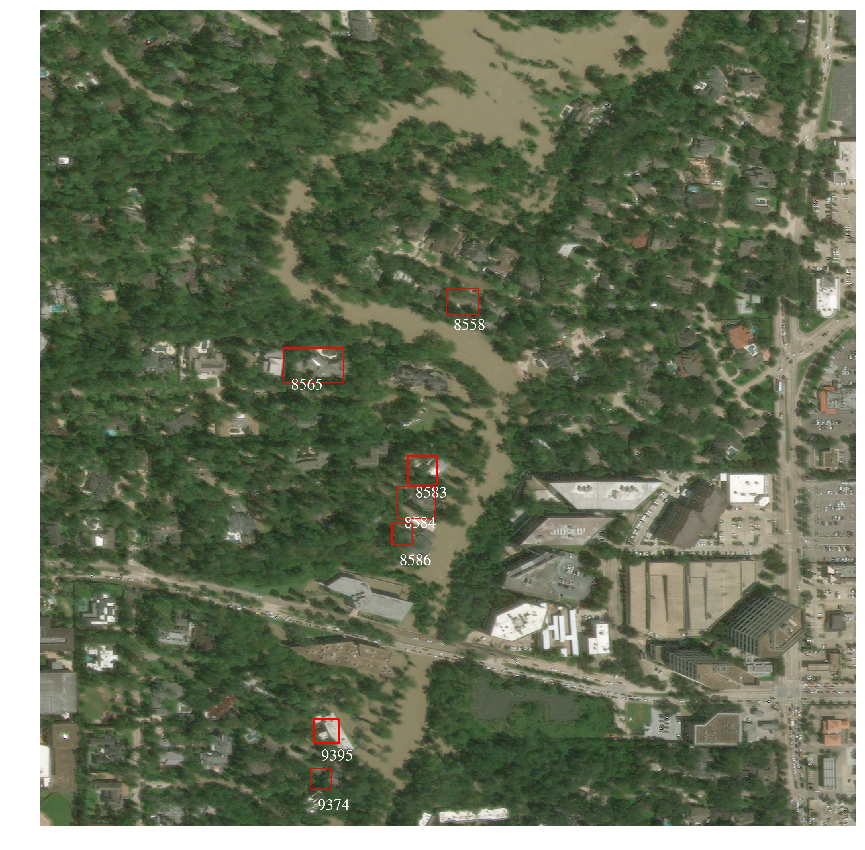

In [126]:
#Load an image
path = '/home/ubuntu/anyan/harvey_data/filtered_converted_image/'
#chip_name = '20170829_1040010032211E00_2112023_jpeg_compressed_10_10.tif' # with blackout
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_01.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_04_04.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_05_02.tif'
chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_05_04.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_02.tif'
chip_fullname = path + chip_name
print(chip_fullname)
arr = wv.get_image(chip_fullname)
coords_chip = coords[chips==chip_name]
# print(coords_chip)

# add offsets
# x_off = 15
# y_off = 15
# add_np = np.array([-x_off, -y_off, x_off, y_off])
# coords_chip = np.add(coords_chip, add_np)

# CAUTION: should check the wether the shifted bboxes are within big image boundary

classes_chip = classes[chips==chip_name].astype(np.int64)
uids_chip = uids[chips == chip_name].astype(np.int64)
#labelled = aug.draw_bboxes(arr,coords_chip[classes_chip ==1])
labelled = draw_bboxes_withindex(arr,coords_chip[classes_chip ==1],uids_chip)

#labelled = aug.draw_bboxes(arr,coords[classes ==1])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(labelled)

# print(arr.shape)
# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(arr)

In [61]:
# # delete bboxes based on bbox id
# # i.e.: {chip_name : [0, 2, 3]}
# # return new bbox and its class


# def delete_bbox(img, boxes, classes, chip_name, rows_to_delete):
    
#     if len(rows_to_delete) == 0:
#         return img,  boxes, classes
#     else:
#         # return boxes and classes with clouds removed
#         new_coords = np.delete(boxes, rows_to_delete, axis=0)
#         new_classes = np.delete(classes, rows_to_delete, axis=0)
#         return img, new_coords, new_classes

    





In [84]:
# test
rows_to_delete = [8591, 978]

img, new_coords, new_classes = delete_bbox(arr, coords_chip[classes_chip ==1], classes_chip[classes_chip==1], chip_name, rows_to_delete)

labelled_2 = draw_bboxes_withindex(img, new_coords)

#labelled = aug.draw_bboxes(arr,coords[classes ==1])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(labelled_2)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


TypeError: draw_bboxes_withindex() missing 1 required positional argument: 'uids'

In [43]:
# take absolut path of chip files
# converted to png files

def draw_bbox_on_tiff(chip_path, coords, chips, classes, save_path):
    #Load an image
    #path = '/home/ubuntu/anyan/harvey_data/converted_sample_tiff/'
    
    
    # big tiff name: chip name
    # init to {big_tiff_name : []}
    #big_tiff_dict = dict((k, []) for k in big_tiff_set)

    fnames = glob.glob(chip_path + "*.tif")
    i = 0
    for f in fnames:
        
        chip_name = f.split('/')[-1]
        chip_big_tiff_id_list = chip_name.split('_')[1:3]
        chip_big_tiff_id = '_'.join(chip_big_tiff_id_list)
        print(chip_big_tiff_id)
        #if chip_big_tiff_id not in set(big_tiff_dict.keys()):
         #   big_tiff_dict[chip_big_tiff_id] = list()
          #  big_tiff_dict[chip_big_tiff_id].append(chip_name)
        #else:
            
#         if len(big_tiff_dict[chip_big_tiff_id]) < 5:


           #big_tiff_dict[chip_big_tiff_id].append(chip_name)
        arr = wv.get_image(f)
#             print(arr.shape)
    #         plt.figure(figsize=(10,10))
    #         plt.axis('off')
    #         plt.imshow(arr)
        coords_chip = coords[chips==chip_name]
            #print(coords_chip.shape)
        if coords_chip.shape[0] == 0:
            print('no bounding boxes for this image')
            continue
        classes_chip = classes[chips==chip_name].astype(np.int64)
    #         #We can chip the image into 500x500 chips
    #         c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords, classes=classes, shape=(500,500))
    #         print("Num Chips: %d" % c_img.shape[0])
        labelled = aug.draw_bboxes(arr,coords_chip[classes_chip ==1])
        print(chip_name)
#             plt.figure(figsize=(15,15))
#             plt.axis('off')
#             plt.imshow(labelled)
        subdir_name = save_path + chip_big_tiff_id
        if os.path.isdir(subdir_name):
            save_name = subdir_name +'/' + chip_name + '.png'
            print(save_name)
            labelled.save(save_name)
        else:
            os.mkdir(subdir_name)
            save_name = subdir_name +'/' + chip_name + '.png'
            print(save_name)
            labelled.save(save_name)
           


In [44]:
# path = '/home/ubuntu/anyan/harvey_data/converted_image_tiles_aws/'
# save_path =  '/home/ubuntu/anyan/harvey_data/bbox_debug_png/'
# draw_bbox_on_tiff(path, coords, chips, classes, save_path)

In [45]:
# coords = coords[chips==chip_name]
# classes = classes[chips==chip_name].astype(np.int64)

In [47]:
print(classes)

[1. 1. 1. ... 2. 2. 2.]


[[ 703. 1571.  862. 1685.]
 [1013.  697. 1094.  762.]
 [ 605.  847.  756.  934.]
 [ 917. 1118.  990. 1190.]
 [ 889. 1194.  986. 1275.]
 [ 877. 1288.  928. 1339.]
 [ 665. 1397.  896. 1541.]
 [ 672. 1902.  725. 1954.]
 [ 681. 1778.  744. 1838.]]
[1 1 1 1 1 1 1 1 1]


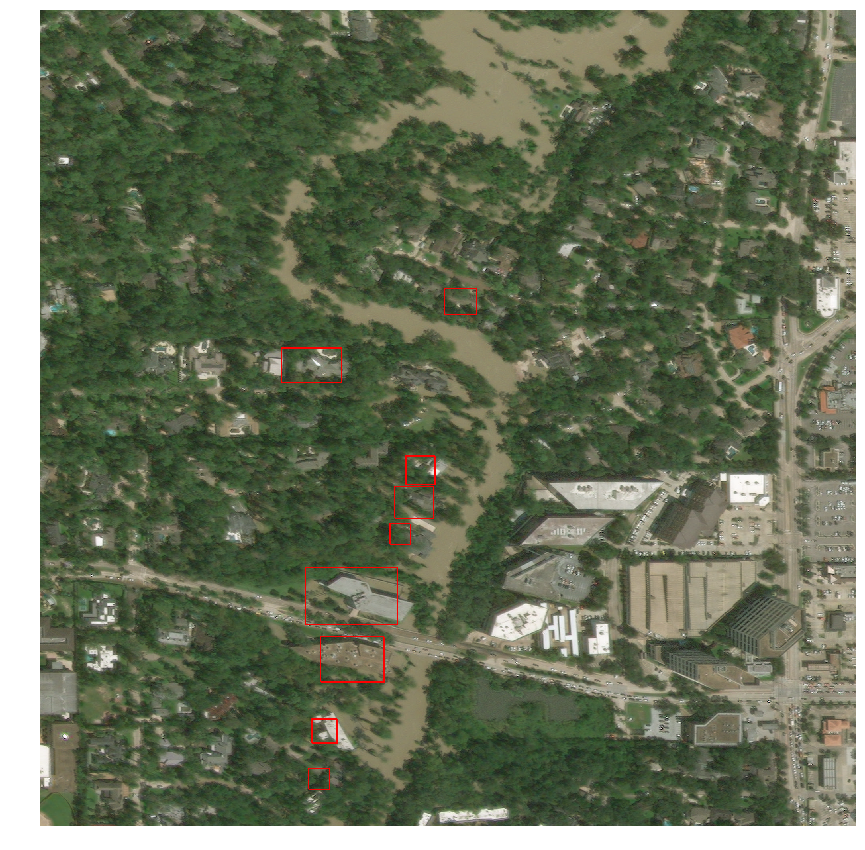

In [48]:
coords_chip = coords[chips==chip_name]
            #print(coords_chip.shape)
print(coords_chip)
classes_chip = classes[chips==chip_name].astype(np.int64)
    #         #We can chip the image into 500x500 chips
    #         c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords, classes=classes, shape=(500,500))
    #         print("Num Chips: %d" % c_img.shape[0])
print(classes_chip)
labelled = aug.draw_bboxes(arr,coords_chip)

#labelled = aug.draw_bboxes(arr,coords[classes ==1])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(labelled)

In [49]:
#We can chip the image into 500x500 chips
c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords_chip, classes=classes_chip, shape=(512,512))
print("Num Chips: %d" % c_img.shape[0])

Num Chips: 16


In [50]:
len(c_box[2])

1

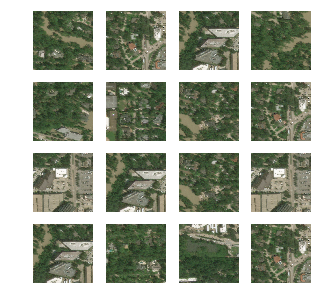

In [51]:
#We can plot some of the chips
fig,ax = plt.subplots(4)
fig.set_figheight(5)
fig.set_figwidth(5)

for k in range(16):
    plt.subplot(4,4,k+1)
    plt.axis('off')
    plt.imshow(c_img[np.random.choice(range(c_img.shape[0]))])

plt.show()

In [52]:
# detect black blocks in an image
# take an img in array format
# determine whether the area of the black portion is larger than a threshold: 0.1
# return True if the img contain large portions of black 


def detect_blackblock(img):
    # check the # of pixels that with RGB values are all equal to 0
    w,h,c = img.shape
    black_pixel_count=0
    threshold = 0.1 * w * h
    
    for i in range(w):
        for j in range(h):
#             print()
            #if img[i,j,0]== 0 and img[i,j,1]== 0 and img[i,j,2]== 0:
            if np.all(img[i,j,:] ==0):
                black_pixel_count+=1
                if black_pixel_count > threshold:
                    return True
    return False
                

    

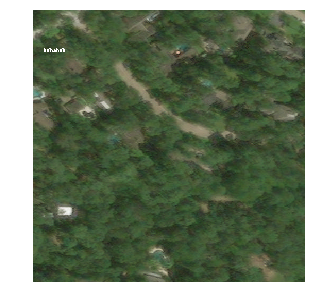

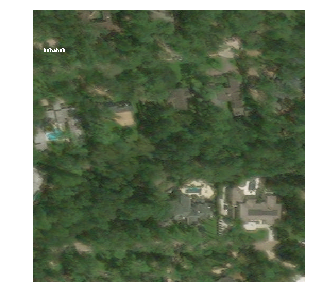

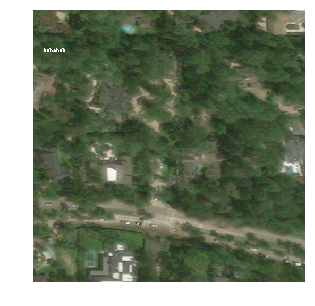

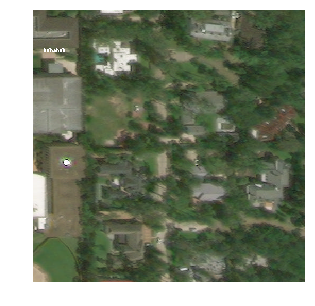

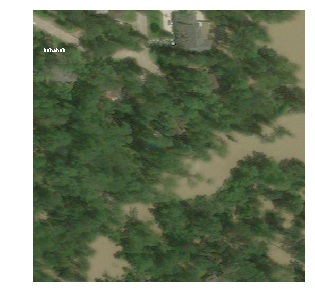

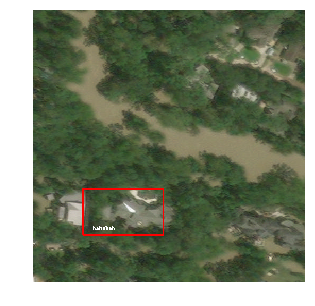

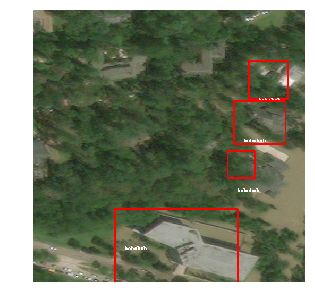

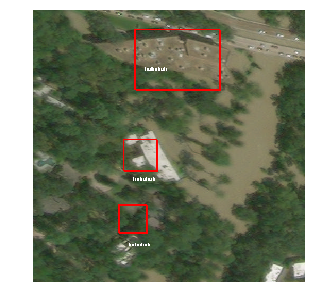

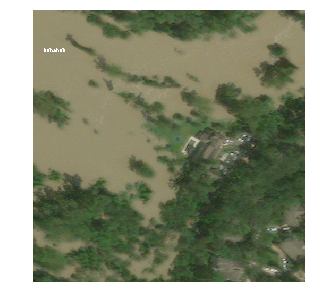

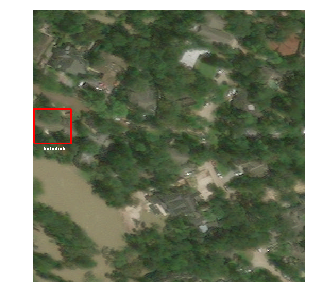

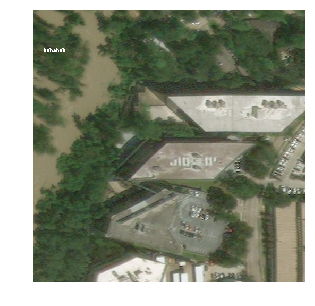

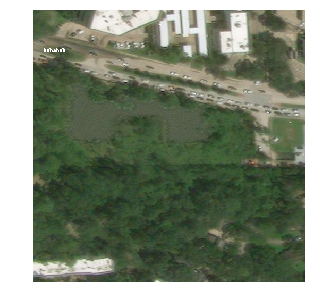

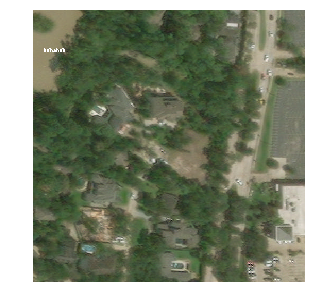

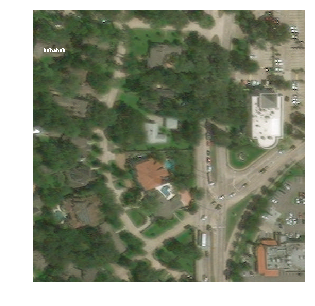

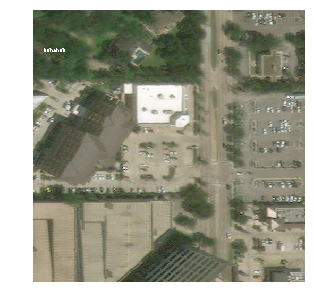

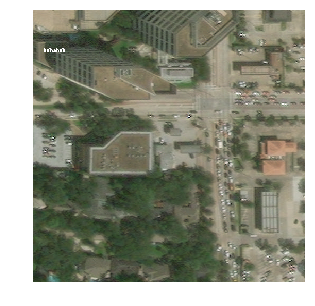

In [54]:
#We can visualize the chips with their labels
for ind in range(0, c_img.shape[0]):
    #ind = np.random.choice(range(c_img.shape[0]))
#     if detect_blackblock(c_img[ind]): # contain black, ignore
#         continue
    #labelled = aug.draw_bboxes(c_img[ind],c_box[ind])
    labelled = draw_bboxes_withindex(c_img[ind],c_box[ind])
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(labelled)

In [15]:
detect_blackblock(arr)

False

In [16]:




# labelled = aug.draw_bboxes(arr,coords[classes ==1])
# plt.figure(figsize=(15,15))
# plt.axis('off')
# plt.imshow(labelled)

In [17]:
# labelled.save("test.png")